### 4. Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

что надо сделать 
1. объединить в одну выборку 
2. провести исследование и выявить тематики о которых говорят в твитах 
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики


In [116]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from string import punctuation
import nltk
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
nltk.download('punkt', quiet=True)
import pymorphy3

# Отключить вывод ошибок
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import gensim.downloader as api

#### Посмотрим на данные и объединим в одну выборку

In [83]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [84]:
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [85]:
def delete_pattern(text, pattern):
    return re.sub(pattern, ' ', text)

In [86]:
#убираем заглавные
df['text'] = df['text'].apply(lambda x: x.lower())

In [87]:
print(df.shape)
df.head()

(226834, 2)


,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"да, все-таки он немного похож на него. но мой ...",positive
2,rt @katiacheh: ну ты идиотка) я испугалась за ...,positive
3,"rt @digger2912: ""кто то в углу сидит и погибае...",positive
4,@irina_dyshkant вот что значит страшилка :d\nн...,positive


In [92]:
df = df.drop(columns='label') #закоментировано, потому что при перезапуске выпадает в ошибку (т. к. столбец уже удален)

In [89]:
print(df.index)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            111913, 111914, 111915, 111916, 111917, 111918, 111919, 111920,
            111921, 111922],
           dtype='int64', length=226834)


In [90]:
#df=df.set_index('id')


In [93]:
df.head()

,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"да, все-таки он немного похож на него. но мой ..."
2,rt @katiacheh: ну ты идиотка) я испугалась за ...
3,"rt @digger2912: ""кто то в углу сидит и погибае..."
4,@irina_dyshkant вот что значит страшилка :d\nн...


#### Получаем векторные представления новостей

In [95]:
!pip install natasha

In [96]:
from gensim.corpora.dictionary import Dictionary
import natasha
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel

In [97]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Инна\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [98]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [99]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [100]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy3.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [101]:
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста.

df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

100%|███████████████████████████████████████████████████████████████████████| 226834/226834 [00:04<00:00, 45378.54it/s]


In [102]:
df['text'].iloc[:10]

0    firsttimee хоть я и школота но поверь у нас то...
1    да всетаки он немного похож на него но мой мал...
2      rt katiacheh ну ты идиотка я испугалась за тебя
3    rt digger "кто то в углу сидит и погибает от г...
4    iri adyshka t вот что значит страшилка d но бл...
5    ну любишь или нет  я не знаю кто ты бляd httpt...
6    rt spoo lamer ох d ну это конечно же twi kleay...
7    rt veregijytaqo у тебя есть ухажёр нет  мои уш...
8          поприветствуем моего нового читателя alexey
9    теперь у меня есть частичка сиднея  syd ey syd...
Name: text, dtype: object

In [103]:
# Запускаем лемматизацию текста. 

df['text'] = df['text'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████| 226834/226834 [01:01<00:00, 3704.14it/s]


In [104]:
df['text'].iloc[:10]

0    [firsttimee, школотый, поверь, самый, общество...
1    [всетаки, немного, похожий, мальчик, всё, равн...
2                 [rt, katiacheh, идиотка, испугаться]
3    [rt, digger, угол, сидеть, погибать, голод, ещ...
4    [iri, adyshka, значит, страшилка, блинпосмотре...
5                [любить, знать, бля, httptcobrfe, gu]
6    [rt, spoo, lamer, ох, это, twi, kleayo, друг, ...
7               [rt, veregijytaqo, ухажёр, ухо, жрать]
8          [поприветствовать, новый, читатель, alexey]
9    [частичка, сидней, syd, ey, syd, eyoperahouse,...
Name: text, dtype: object

#### Обучение модели

In [105]:
# сформируем список наших текстов
texts = list(df['text'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [106]:
N_topic = 20  #число тем гиперпараметр

In [107]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=2) 

CPU times: total: 2min 37s
Wall time: 2min 37s


In [108]:
from gensim.test.utils import datapath

In [109]:
# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [110]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [111]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(df['text'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['rt', 'katiacheh', 'идиотка', 'испугаться']


[(0, 0.012503222),
 (1, 0.37985167),
 (2, 0.012503221),
 (3, 0.012503221),
 (4, 0.012503221),
 (5, 0.012503221),
 (6, 0.012503221),
 (7, 0.012503221),
 (8, 0.012503221),
 (9, 0.3950903),
 (10, 0.012503221),
 (11, 0.012503221),
 (12, 0.012503221),
 (13, 0.012503221),
 (14, 0.012503221),
 (15, 0.012503221),
 (16, 0.012503221),
 (17, 0.012503221),
 (18, 0.012503221),
 (19, 0.012503221)]

После обучения темы выглядят следующим образом

In [112]:
x = lda.show_topics(num_topics=N_topic, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: rt никто работать нравиться минута это твит чувствовать чувство ya
topic_1: большой забыть каникулы вставать слово rt както холодно приехать никак
topic_2: думать жизнь понимать rt скучно пройти маленький это вчера устать
topic_3: день сегодня весь настроение ходить правда деньга увидеть столько должный
topic_4: любить любимый rt очень прийти сильно давать город бывать папа
topic_5: плохо бля видеть каждый изз это блядь казаться rt всё
topic_6: оо остаться дело экзамен телефон купить учить дать всё ужасный
topic_7: школа неделя найти нужный фотка простить мало глаз rt получиться
topic_8: человек который писать хотеться это сказать стать всё снова мочь
topic_9: друг голова рука rt взять помочь надоесть сила аж вернуть
topic_10: спать идти час утро сидеть ночь бояться выйти весь rt
topic_11: знать смотреть нужно плохой фильм хотя жалко это месяц начало
topic_12: делать болеть пойти урок rt домой ещё пиздец всё смочь
topic_13: хотеть почему мама сделать говорить rt всё это скоро 

Функция, которая возвращает векторное представление твита

In [113]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [114]:
get_lda_vector(lda, df['text'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.43407556,
       0.        , 0.        , 0.        , 0.        , 0.15045395,
       0.        , 0.        , 0.15040292, 0.        , 0.15043329])

Создадим новый датафрейм на основе полученных векторов

In [115]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in df['text'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['id'] = df.index
topic_matrix = topic_matrix[['id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(20)

,id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.150454,0.000000,0.000000,0.150403,0.000000,0.150433
1,1,0.135072,0.000000,0.135118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.134226,0.000000,0.000000,0.495576,0.000000,0.000000
2,2,0.012503,0.380222,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,...,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.326673,0.098407,0.115041,0.104701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,0.000000,0.271562,0.481961,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.140216,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,0.010002,0.010002,0.010002,0.010002,0.210033,0.210031,0.010002,0.010002,0.010002,...,0.010002,0.210033,0.010002,0.010002,0.010002,0.010002,0.010002,0.209877,0.010002,0.010002
6,6,0.000000,0.000000,0.240691,0.163670,0.000000,0.000000,0.168364,0.157152,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.012500,0.012500,0.012500,0.343865,0.012500,0.012500,0.012500,0.012500,0.012500,...,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500
8,8,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.512380,...,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.012503,0.262563,0.012503
9,9,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,...,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,0.524923,0.025004


<function matplotlib.pyplot.show(close=None, block=None)>

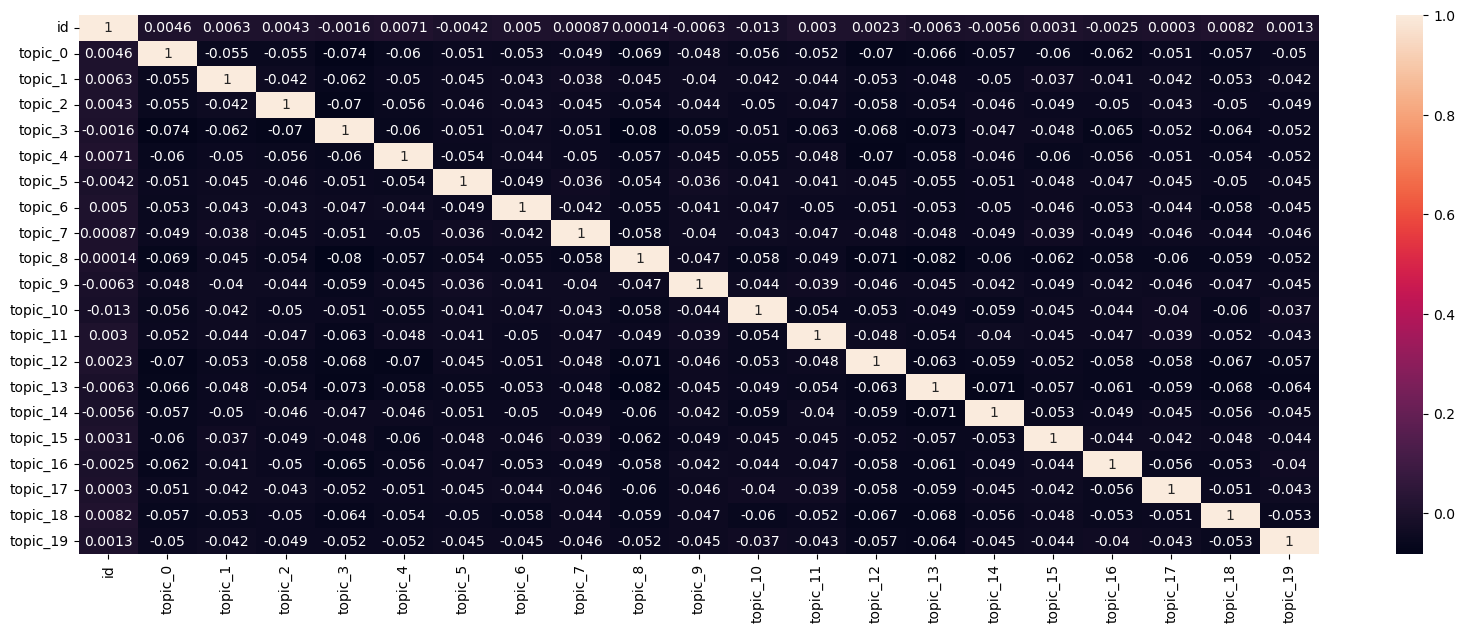

In [143]:
plt.figure(figsize = (20,7))
cor = topic_matrix.corr()
sns.heatmap(cor, annot=True)
plt.show


Тепловая карта показала, что в принципе распределение тем по твитам очень приблизительное. Нельзя сказать, что какая то из тем выделяется больше других.